# Understanding the influence of hyperparameters

## An overview of the hyperparameters

The main hyperparameter inputs to the hdphmm algorithm are named alpha0_p_kappa0, rho0 and gamma0. 

- **gamma0**: This is the concentration parameter for the global discrete probability measure $G_0$. $G_0 \sim DP(gamma0, H)$ or more formally: $G_0 = \sum_{k=1}^{\infty} \beta_k \delta_{\theta_k}~~,~~\theta_k \sim H$. H is just a base measure from which discrete values are drawn. H isn't explicitly used since we actually assign the weights, $\beta$, to discrete entries in a vector. 


- **alpha0_p_kappa0** : this hyperparameter is actually the sum of two hyperparameters: alpha0 and kappa0. 
    - **alpha0**: this is the concentration parameter of the dirichlet process which draws from $G_0$, DP(alpha0, $G_0$). To construct a transition matrix, we draw rows $G_j$ from this DP: $G_j \sim$ DP(alpha0, $\beta$). More formally: $G_j = \sum_{k=1}^{\infty} \pi_{jk} \delta_{\theta_k}~~,~~\theta_k \sim H$. Notice that it uses the same $\delta_{\theta_k} values. 
    - **kappa0**: this is the sticky hyper parameter. Increased values of kappa0 increase the self-transition probabilities by adding weight to the diagonals of the transition matrix
    
    
- **rho0**: although kappa0 is the sticky parameter, rho0 is the hyperparameter that controls kappa0. kappa0 = alpha0_p_kappa0 * rho0. alpha0 = alpha0_p_kappa0 * (1 - rho0). It is implemented this way to reduce user error. If kappa and alpha0 are of the same magnitude, you won't get the same sticky effect. kappa0 being large relative to alpha0 is the important think for the sticky model.


## The influence of the hyperparameters on the transition matrix

gamma0, alpha0_p_kappa0 and rho0 are primarily used to sample the transition matrix. It is easiest to 

In this section we will look at the _sample_distributions() method. This method is used to estimate the rows of the transition matrix, pi_z, the initial distribution of states, pi_init, the emission weights, pi_s, and the global transition distribution, beta. The hyperparameters alpha0_p_kappa0 strongly influence these distributions

/home/bcoscia/PycharmProjects/hdphmm/hdphmm/utils/random.py:235: RuntimeWarning: invalid value encountered in true_divide
  x /= x.sum(axis=0)


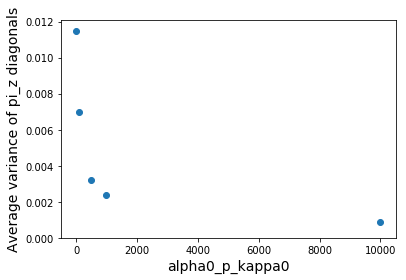

In [73]:
# reproduction of _sample_distributions() method modified to make varying parameters easier.

def sample_distributions(alpha0_p_kappa0, rho, gamma0):

    alpha0 = alpha0_p_kappa0 * (1 - rho)  # DP concentration parameter. Higher alpha0 means higher confidence in parameters
    kappa0 = alpha0_p_kappa0 * rho  # sticky parameter
    # alpha0 + kappa0 = alpha0_p_kappp0

    sigma0 = 1

    max_states = 5  # This is chosen by the user

    Ks = 1  # this is for SLDS model
    pi_z = np.zeros([max_states, max_states])  # transition matrix
    pi_s = np.zeros([max_states, Ks])  # emission weights

    barM = np.zeros([max_states, max_states])  # barM starts off as a zero matrix

    # Draw beta vector from dirichlet distribution. The first part of the hierarchy
    #beta_vec = random.randdirichlet(barM.sum(axis=0) + gamma0 / max_states)[:, 0]
    beta_vec = np.random.dirichlet(barM.sum(axis=0) + gamma0 / max_states)
    
    # if not sticky, barM = M. Otherwise barM is the same as M but with modified diagonals. For very stick models (i.e. rho0
    # = 0.99), the diagonals are nearly zero. I think it is meant to convert barM to an M matrix that is more consistent with
    # a non-sticky model

    N = np.zeros([max_states + 1, max_states])  # transition count matrix
    Ns = np.zeros([max_states, 1])  # I'll come back to what this is exactly

    for j in range(max_states):
        vec = alpha0 * beta_vec + N[j, :]  # count matrix + some
        vec[j] += kappa0  # add sticky parameter to give increased weight to diagonals

        pi_z[j, :] = random.randdirichlet(vec)[:, 0]
        pi_s[j, :] = random.randdirichlet(Ns[j, :] + sigma0 / Ks)[:, 0]

    pi_init = random.randdirichlet(alpha0 * beta_vec + N[max_states, :])[:, 0]
    
    return pi_z

alpha0_p_kappa0 = 100  # play with this value

a_gamma = 1
b_gamma = 0.01
gamma0 = a_gamma / b_gamma  # influences the base disribution, beta

# control the sticky parameter by changing c and d
c = 100
d = 1

rho = c / (c + d)   # hyperparameter for calculating sticky parameter

rho = 0.99
gamma = 100
diags = []
alphas = [1, 100, 500, 1000, 10000]
for alpha in alphas:
    trials = []
    for i in range(1000):
        pi_z = sample_distributions(alpha, rho, gamma)
        trials.append(np.std(np.diag(pi_z)))
    
    diags.append(np.mean(trials))

plt.scatter(alphas, diags)
plt.ylim(0, 1.05 * max(diags))
plt.xlabel('alpha0_p_kappa0', fontsize=14)
plt.ylabel('Average variance of pi_z diagonals', fontsize=14)
plt.show()

For a constant value of rho0, higher values of alpha0_p_kappa0 give higher probabilities to off-diagonals of pi_z. Higher values of alpha0_p_kappa0 also lower the variance of the diagonal values.

For constant alpha0_p_kappa0, higher values of rho0 concentrate probabilities to the diagonals pi_z.

rho0 and alpha0_p_kappa0 work together. 

Under normal conditions, the gamma0 hyperparameter actually has very little influence on the values in the transition matrix. Gamma0 is the concentration parameter used when drawing beta_vec from a dirichlet process (which is an essential part of the hierarchy). It will, of course, have a major influnce on beta_vec.

In the first iteration, there are no states counts, so beta_vec is drawn from symmetric dirichlet distribution about 1 / max_states:

In [34]:
max_states = 5
gamma0 = 100  # play with this

barM = np.zeros([max_states, max_states])

beta_vec = np.random.dirichlet(barM.sum(axis=0) + gamma0 / max_states)

print(beta_vec)

[0.1911 0.222  0.2951 0.1547 0.1371]


As gamma0 increases, the values of beta vec converge around 1 / max_states. 

To build the transition matrix, beta_vec is multiplied by alpha0 (from alpha0_p_kappa0). For large values of alpha0, this can be significant:

In [38]:
alpha0 = 10000  # play with this

pi_z = np.zeros([max_states, max_states])

print(beta_vec)

for j in range(max_states):
    vec = alpha0 * beta_vec # + N[j, :]  # N[j, :] = 0 for first iteration
    #vec[j] += kappa0  # don't use the sticky model for this

    pi_z[j, :] = random.randdirichlet(vec)[:, 0]
    
print(pi_z)

[0.1911 0.222  0.2951 0.1547 0.1371]
[[0.1956 0.218  0.2987 0.15   0.1378]
 [0.1912 0.2279 0.2974 0.1478 0.1357]
 [0.1944 0.2261 0.292  0.152  0.1355]
 [0.2013 0.2141 0.2982 0.156  0.1303]
 [0.1919 0.2229 0.293  0.1576 0.1346]]


In the above example, alpha0 has a huge effect on how close the rows of the transition matrix are to beta_vec. Large values of alpha0 lead to rows that are closer to beta_vec.

Now let's look at the sticky model.

In [58]:
alpha0_p_kappa0 = 100000

rho = .9  # sticky hyperparameter. Closer to 1 shifts most of alpha0_p_kappa0 to kappa0

alpha0 = alpha0_p_kappa0 * (1 - rho)  # DP concentration parameter. Higher alpha0 means higher confidence in parameters
kappa0 = alpha0_p_kappa0 * rho  # sticky parameter

pi_z = np.zeros([max_states, max_states])

print(beta_vec)

for j in range(max_states):
    vec = alpha0 * beta_vec # + N[j, :]  # N[j, :] = 0 for first iteration
    vec[j] += kappa0

    pi_z[j, :] = np.random.dirichlet(vec)
    
print(pi_z)

[0.1911 0.222  0.2951 0.1547 0.1371]
[[0.9194 0.0223 0.0296 0.0154 0.0133]
 [0.0193 0.9219 0.0304 0.0152 0.0133]
 [0.019  0.0223 0.9301 0.0151 0.0136]
 [0.0187 0.0228 0.0294 0.915  0.0141]
 [0.0195 0.0222 0.0294 0.0159 0.913 ]]


You can see for yourself that when rho0 is high (say 0.99), most of the weight is shifted to the diagonals. Higher values of alpha0_p_kappa0 will make the off diagonals proportionally similar to the beta_vec, but the probabilities are very small. Lower values of alpha0_p_kappa0 tend to shift all of the probability to the diagonals.

Intermediate values of rho0 still put most of the probability on the diagonals, but with more variability in those values as well as on the off-diagonals. Higher values of alpha0_p_kappa0 once again reduce the variance in the diagonal values.

Let's look at further iterations where we now have a state count matrix:

In [72]:
alpha0_p_kappa0 = 1000000

rho = 0.2  # sticky hyperparameter. Closer to 1 shifts most of alpha0_p_kappa0 to kappa0

alpha0 = alpha0_p_kappa0 * (1 - rho)  # DP concentration parameter. Higher alpha0 means higher confidence in parameters
kappa0 = alpha0_p_kappa0 * rho  # sticky parameter

pi_z = np.zeros([max_states, max_states])

# some made up transitions
N = np.array([[100,  0,   0,  5,  3],
             [  0, 50,   1,  1,  0],
             [  0,  1, 125,  2,  2],
             [  5,  1,   0, 10,  1],
             [  3,  0,   2,  1, 60]])

N *= 1  # scale influence of N

print(beta_vec)

for j in range(max_states):
    vec = alpha0 * beta_vec + N[j, :] 
    vec[j] += kappa0

    pi_z[j, :] = np.random.dirichlet(vec)
    
print(pi_z)

[0.1911 0.222  0.2951 0.1547 0.1371]
[[0.353  0.1775 0.2365 0.1236 0.1094]
 [0.1529 0.3782 0.2359 0.1236 0.1095]
 [0.1521 0.1776 0.4371 0.1238 0.1094]
 [0.153  0.1775 0.2363 0.3235 0.1096]
 [0.1527 0.1777 0.2365 0.1243 0.3088]]


For rho0 = 0 (non-sticky model), higher values of alpha0_p_kappa0 relative to the entries in N cause the entries in N to be more or less ignored. Lower values of alpha0_p_kappa0 cause the algorithm to listen to N more.

The same is true for the sticky model but to a lesser extent. The weight is shifted to the diagonals.

# Resampling the hyperparameters

## Gamma priors

2-parameter gamma priors are placed on both alpha0_p_kappa0 and gamma0.

Gamma$(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha - 1}e^{-\beta x}}{\Gamma(\alpha)} $ for $ x > 0~,~\alpha, \beta > 0$

a_alpha and b_alpha are used to sample values of alpha0_p_kappa0. a_gamma and b_gamma are used to samples values of gamma0. a and b stand for alpha and beta respectively.

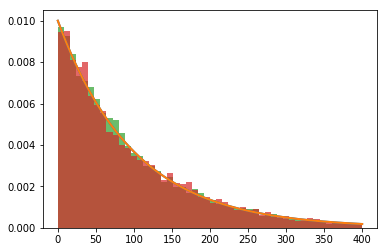

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma
from hdphmm.utils import random

alpha = 1
beta = 0.01
xupper = 400

# Plot the PDFs
x = np.linspace(0, xupper, 1000)

# from scipy docs: gamma.pdf(x, a, loc, scale) is identically equivalent to gamma.pdf(y, a) / scale 
# with y = (x - loc) / scale
plt.plot(x, gamma.pdf(x, alpha, scale=1/beta), lw=2)
plt.plot(x, gamma.pdf(x * beta, alpha) * beta, lw=2)

# Now let's generate Gamma distributions a few ways
data1 = np.random.gamma(alpha, scale=1/beta, size=10000)  # this is how one would write a 2-parameter Gamma
data2 = np.random.gamma(alpha, size=10000) / beta  # this is how hdphmm.py does it

plt.hist(data1, bins=50, alpha=0.7, density=True, range=(0, xupper))
plt.hist(data2, bins=50, alpha=0.7, density=True, range=(0, xupper))

plt.show()

## alpha0_p_kappa0

a_alpha and b_alpha are used in combination to generate the hyperparameter alpha0_p_kappa0.

Their first use is in the _sample_hyperparams_init() function. Let's set some values for a_alpha and b_alpha.

In [3]:
import numpy as np

a_alpha = 1
b_alpha = 0.01

hyperparams = dict()

# The calculation of the initial value of alpha0_p_kappa0
alpha0_p_kappa0 = a_alpha / b_alpha

print(alpha0_p_kappa0)

100.0


They are also used to resample the hyperparameters later with the gibbs_conparam() method.

In [4]:
from hdphmm.utils import random

def gibbs_conparam(alpha, numdata, numclass, a_alpha, b_alpha, numiter):
    """ Auxiliary variable resampling of DP concentration parameter. reproduction of gibbs_conparam.m
    """

    numgroup = numdata.size
    totalclass = numclass.sum()

    A = np.zeros([numgroup, 2])
    A[:, 0] = alpha + 1
    A[:, 1] = numdata

    for i in range(numiter):
        # beta auxiliary variables (the beta distribution is the 2D case of the dirichlet distribution)
        # xj = np.array([np.random.dirichlet(a) for a in A])
        xj = np.array([random.randdirichlet(a) for a in A])  # REMOVE

        xx = xj[:, 0]

        # binomial auxiliary variables -- debug this if there is an issue. I think this is right though
        zz = np.less(np.multiply(np.random.uniform(size=numgroup), alpha + numdata), numdata)

        gammaa = a_alpha + totalclass - sum(zz)

        gammab = b_alpha - sum(np.log(xx))

        # alpha = np.random.gamma(gammaa) / gammab
        alpha = (random.randomgamma(gammaa) / gammab)[0, 0]  # REMOVE

    return alpha

Nkdot = np.array([9, 618, 15, 39, 1, 108, 907, 296, 5, 1]) # Nkdot = N.sum(axis=1)
Mkdot = np.array([9, 199, 14, 36, 1,  77, 233, 150, 5, 1]) # Mkdot = M.sum(axis=1)

# resampling
alpha0_p_kappa0 = gibbs_conparam(alpha0_p_kappa0, Nkdot, Mkdot, a_alpha, b_alpha, 50)

print(alpha0_p_kappa0)

107.89779685284896


Nkdot and Mkdot are sums of the rows which make up matrices N and M. They basically quantify the amount of time spent in each state. The values above are taken from real data. I removed all of the zero entries.

N is a matrix of state counts. If there is a transition from state i to j, the (i, j) entry of N is incremented by 1.

M can be thought of as a tempered version of N which incorporates the sticky parameter and lowers extreme values in the count matrix. (see the section 'The M matrix' for more detail).

Note how Mkdot entries are lower than Nkdot due to the tempering effect.

Now let's break down gibbs_conparam()

[101.   9.] [0.9042 0.0958]
[101. 618.] [0.1504 0.8496]
[101.  15.] [0.8774 0.1226]
[101.  39.] [0.7214 0.2786]
[101.   1.] [0.9995 0.0005]
[101. 108.] [0.5195 0.4805]
[101. 907.] [0.0766 0.9234]
[101. 296.] [0.2568 0.7432]
[101.   5.] [0.9271 0.0729]
[101.   1.] [0.9961 0.0039]


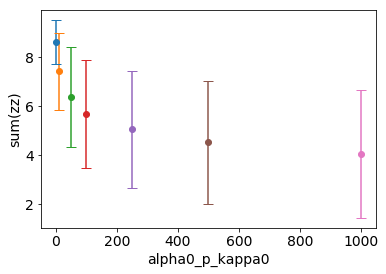

In [5]:
alpha0_p_kappa0 = a_alpha / b_alpha  # reset the value of alpha0_p_kappa0

numgroup = Nkdot.size
totalclass = Mkdot.sum()

A = np.zeros([numgroup, 2])
A[:, 0] = alpha0_p_kappa0 + 1  # alpha0_p_kappa0 strongly influences the draws from the dirichlet distribution
A[:, 1] = Nkdot

# xj is just a list of pairs of alpha0_p_kappa0 and the Nkdot values
xj = np.zeros_like(A)
for j, a in enumerate(A):
    xj[j] = random.randdirichlet(a)[:, 0]
    print(a, xj[j])

# now break down the following line into something more readable
# zz = np.less(np.multiply(np.random.uniform(size=numgroup), alpha0_p_kappa0 + Nkdot), Nkdot)
term1 = np.random.uniform(size=numgroup)  # draw random uniform numbers between 0 and 1
term2 = np.multiply(term1, alpha0_p_kappa0 + Nkdot)  # element-wise multiplication. Higher alpha0_p_kappa0 = higher term2 entries
zz = np.less(term2, Nkdot)  # True for each element less than corresponding Nkdot element. Higher alpha0_p_kappa0 = less True values

# could plot this as function of alpha0_p_kappa0
alpha0_p_kappa0 = 1
output = []

def sensitivity(alpha):
    
    for i in range(1000):
        output.append(np.less(np.multiply(np.random.uniform(size=numgroup), alpha + Nkdot), Nkdot).sum())
        
    return output

fig, ax = plt.subplots()
for a in [1, 10, 50, 100, 250, 500, 1000]:
    out = sensitivity(a)
    ax.errorbar(a, np.mean(out), yerr=np.std(out), marker='o', capsize=5)

ax.tick_params(labelsize=14)
ax.set_xlabel('alpha0_p_kappa0', fontsize=14)
ax.set_ylabel('sum(zz)', fontsize=14)
plt.show()

As alpha0_p_kappa0 increases, the number of True values in zz decreases.

In [6]:
xx = xj[:, 0]  # first column of draws from dirichlet distribution

# now we modify a_alpha and b_alpha (named as gammaa and gammab respectively)
gammaa = a_alpha + totalclass - sum(zz)  # totalclass is the sum of Mkdot
# as alpha0_p_kappa0 increases, sum(zz) decreases, gammaa goes up

gammab = b_alpha - sum(np.log(xx))  # increases with alpha0_p_kappa0, since weights will be higher on first column of xj

# so gammaa and gammab increase with alpha0_p_kappa0

# a lot of variability in this step
alpha = np.random.gamma(gammaa) / gammab
#alpha = (random.randomgamma(gammaa) / gammab)[0, 0]  # REMOVE
print(alpha)

101.40881063069605


We just stepped through a single iteration of gibbs_conparam(). Let's see how the initial value of alpha0_p_kappa0 influences the sampled value.

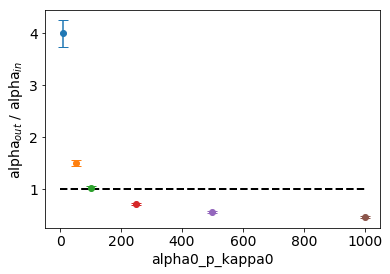

In [7]:
a_alpha = 1.0
b_alpha = 0.01
alpha0_p_kappa0 = a_alpha / b_alpha  # reset the value of alpha0_p_kappa0

Nkdot = np.array([9, 618, 15, 39, 1, 108, 907, 296, 5, 1]) #/ 2
Mkdot = np.array([9, 199, 14, 36, 1,  77, 233, 150, 5, 1]) #/ 2

# Nkdot = np.array([3, 1548, 47, 180, 1, 16, 5, 184, 14, 1])
# Mkdot = np.array([3, 244, 37, 99, 1, 16, 5 ,104, 10, 1])

# Nkdot = np.array([1, 18, 29, 11, 1738, 14, 2, 25, 160, 1])
# Mkdot = np.array([1, 15, 24, 10, 260,  12, 2, 21, 92 , 1])

def gibbs_sensitivity(a, ntrials=10):
    
    output = np.zeros([ntrials])
    for i in range(ntrials):
        output[i] = gibbs_conparam(a, Nkdot, Mkdot, a_alpha, b_alpha, 50)
        
    return output

fig, ax = plt.subplots()
for a in [10, 50, 100, 250, 500, 1000]:
    out = gibbs_sensitivity(a)
    ax.errorbar(a, np.mean(out)/a, yerr=np.std(out)/a, marker='o', capsize=5)

#print(gibbs_sensitivity(40, ntrials=50).mean())

ax.plot([0, 1000], [1, 1], '--', color='black', lw=2)

ax.tick_params(labelsize=14)
ax.set_xlabel('alpha0_p_kappa0', fontsize=14)
ax.set_ylabel('alpha$_{out}$ / alpha$_{in}$', fontsize=14)
    
plt.show()

When alpha0_p_kappa0 is too small, the new value is adjusted upwards. When alpha0_p_kappa0 is too large, it is adjusted downwards. If we kept plugging alpha0_p_kappa0 into gibbs_conparam(), it would stop changing (represented by the black dashed line). This is the purpose of Gibbs sampling.

So far, we have only seen how alpha0_p_kappa0 is generated and resampled. Let's see how it's used in the actual HDPHMM. 

## M, barM and sum_w

M is generated based on the _sample_tables() and randnumtable() methods reproduced below:

In [267]:
def _sample_tables(hyperparams):
    """ reproduction of sample_tables.m
    """

    rho0 = hyperparams['rho0']  # sticky hyperparameter
    alpha0 = hyperparams['alpha0_p_kappa0'] * (1 - rho0)
    kappa0 = hyperparams['alpha0_p_kappa0'] * rho0

    N = self.stateCounts['N']

    # sample M, where M(i, j) = number of tables in restaurant i served dish j

    alpha = self.beta_vec * np.ones([self.max_states, self.max_states]) * alpha0 + kappa0 * np.eye(self.max_states)
    alpha = np.vstack((alpha, alpha0 * self.beta_vec))

    M = self.randnumtable(alpha, N)

    barM, sum_w = self.sample_barM(M, self.beta_vec, rho0)

    self.stateCounts['M'] = M
    self.stateCounts['barM'] = barM
    self.stateCounts['sum_w'] = sum_w

M is generated by the function randnumtable(alpha, N) inside the method _sample_tables().

Mathematically speaking, alpha is formulated by stacking the weight vector, beta, on top of itself n times (where n is the length of the beta vector), multiplying it by a parameter, alpha0, and then adding another parameter, kappa0, to the diagonals. alpha0 and kappa0 add up to alpha0_p_kappa0, hence the name. And the rows of alpha add up to alpha0_p_kappa0! If one thinks of alpha as analogous to the probability transition matrix, it is clear how a significant kappa0 value (rho0 near 1) can shift transitional probabilities to self-transitions.

Here is a reproduction of randnumtable(alpha, N):

In [82]:
def randnumtable(alpha, numdata):
    """ Reproduction of randnumtable.m
    """

    numtable = np.zeros_like(N)

    for i in range(numdata.shape[1]):
        for j in range(numdata.shape[0]):
            if numdata[j, i] > 0:
                numtable[j, i] = 1 + sum(np.random.uniform(size=numdata[j, i] - 1) <
                                         (np.ones([numdata[j, i] - 1]) * alpha[j, i]) / (alpha[j, i] +
                                                                                         np.arange(1,
                                                                                                   numdata[j, i])))
    numtable[numdata == 0] = 0

    return numtable

Let's break down this function a little and understand how the entries in alpha and N work together.

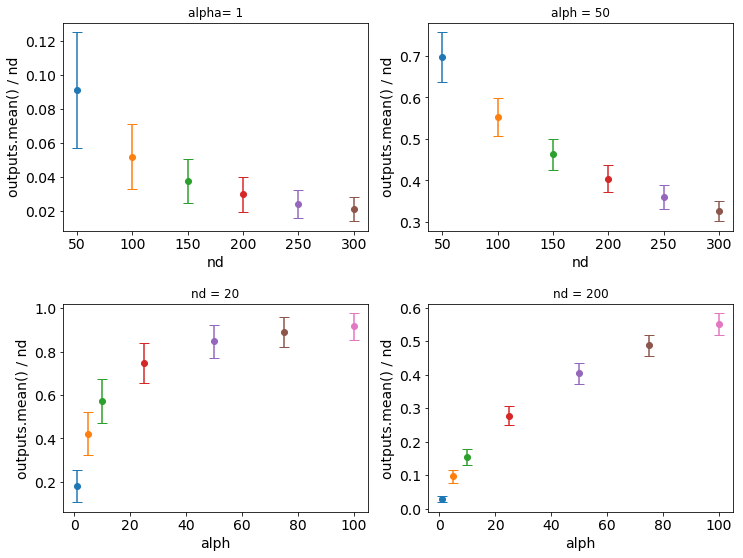

In [78]:
import matplotlib.pyplot as plt

def single_randnumtable_iteration(nd, alph):
    
    term1 = np.random.uniform(size=nd - 1)  # generate a vector of uniform random numbers
    term2 = np.ones([nd - 1]) * alph  # turn this alpha value into a vector of the same alpha
    term3 = alph + np.arange(1, nd)
    
    return 1 + sum(term1 < term2 / term3)

fig, ax = plt.subplots(2, 2, figsize=(12, 9))

alph = 1
for nd in [50, 100, 150, 200, 250, 300]:
    outputs = np.zeros([1000])
    for i in range(outputs.size):
        outputs[i] = single_randnumtable_iteration(nd, alph)
    
    ax[0, 0].errorbar(nd, outputs.mean() / nd, yerr=outputs.std() / nd, marker='o', capsize=5)

ax[0, 0].tick_params(labelsize=14)
ax[0, 0].set_ylabel('outputs.mean() / nd', fontsize=14)
ax[0, 0].set_xlabel('nd', fontsize=14)
ax[0, 0].set_title('alpha= %d' % alph)
    
alph = 50
for nd in [50, 100, 150, 200, 250, 300]:
    outputs = np.zeros([1000])
    for i in range(outputs.size):
        outputs[i] = single_randnumtable_iteration(nd, alph)
    
    ax[0, 1].errorbar(nd, outputs.mean() / nd, yerr=outputs.std() / nd, marker='o', capsize=5)

ax[0, 1].tick_params(labelsize=14)
ax[0, 1].set_ylabel('outputs.mean() / nd', fontsize=14)
ax[0, 1].set_xlabel('nd', fontsize=14)
ax[0, 1].set_title('alph = %d' % alph)

nd = 20
for alph in [1, 5, 10, 25, 50, 75, 100]:
    outputs = np.zeros([1000])
    for i in range(outputs.size):
        outputs[i] = single_randnumtable_iteration(nd, alph)
    
    ax[1, 0].errorbar(alph, outputs.mean() / nd, yerr=outputs.std() / nd, marker='o', capsize=5)

ax[1, 0].tick_params(labelsize=14)
ax[1, 0].set_ylabel('outputs.mean() / nd', fontsize=14)
ax[1, 0].set_xlabel('alph', fontsize=14)
ax[1, 0].set_title('nd = %d' % nd)
    
nd = 200
for alph in [1, 5, 10, 25, 50, 75, 100]:
    outputs = np.zeros([1000])
    for i in range(outputs.size):
        outputs[i] = single_randnumtable_iteration(nd, alph)
    
    ax[1, 1].errorbar(alph, outputs.mean() / nd, yerr=outputs.std() / nd, marker='o', capsize=5)

ax[1, 1].tick_params(labelsize=14)
ax[1, 1].set_ylabel('outputs.mean() / nd', fontsize=14)
ax[1, 1].set_xlabel('alph', fontsize=14)
ax[1, 1].set_title('nd = %d' % nd)

fig.subplots_adjust(hspace=0.35)

plt.show()

As nd increases, at constant alph, the mean output of single_randnumtable_iteration() decreases relative to nd. For higher values of alph, the output relative to nd is higher.

As alph increases, at constant nd, the mean output increases relative to nd. For higher values of nd, the output relative to nd is lower.

Based on this insight, M is essentially a modified version of N. It tempers the entries of N slightly. The values of heavily weighted entries (high alph) of N with lots of data (number of counts in the transition matrix) are decreased somewhat. Heavily weighted entries with little data are kept the same. Entries with lots of counts but with low weights values are decreased greatly.

See if you can predict the trend in the output of the following:

In [85]:
N = np.array([[10, 100, 1000], [1, 10, 10], [1, 1, 1]])
alpha = np.array([[100, 1, 1], [1, 1000, 1], [1, 1, 1]])

print(N)
print(alpha)

[[  10  100 1000]
 [   1   10   10]
 [   1    1    1]]
[[ 100    1    1]
 [   1 1000    1]
 [   1    1    1]]


In [90]:
m = np.zeros([3, 3])
for i in range(1000):
    m += randnumtable(alpha, N)
    
print(m / 1000)

[[9.55  5.199 7.355]
 [1.    9.951 2.946]
 [1.    1.    1.   ]]


Next, let's understand what barM and sum_w are. Both come from the sample_barM() method

In [285]:
def sample_barM(M, beta_vec, rho0):
    """ reproduction of sample_barM.m

    :param M: matrix of random table numbers
    :param beta_vec: G0 distribution pulled from a dirichlet process
    :param rho0: hyperparameter

    :type M: np.ndarray
    :type beta_vec: np.ndarray
    :type rho0: float

    :return barM
    :return sum_w
    """

    barM = np.copy(M)
    sum_w = np.zeros([M.shape[1]])

    for j in range(M.shape[1]):
        if rho0 > 0:
            p = rho0 / (beta_vec[j] * (1 - rho0) + rho0)
        else:
            p = 0

        # sum_w[j] = np.random.binomial(M[j, j], p)
        sum_w[j] = random.randombinomial(M[j, j], p)  # REMOVE
        barM[j, j] = M[j, j] - sum_w[j]

    return barM, sum_w

let's break down the above function

In [327]:
max_states = 5  # to make things easier

c = 100
d = 1

rho0 = c / (c + d)   # hyperparameter for calcullating sticky parameter

beta_vec = random.randdirichlet(np.zeros([max_states]) + gamma0 / max_states)  # this is beta_vec for the first iteration
#beta_vec[0] = 0.1

M = np.array([[283, 0,   2 ,  1,   0],
              [0,   0,   0,   0,   0],
              [1,   0, 138,   0,   1],
              [1,   0,   2,  10,   0],
              [0,   0,   0,   1,   6],
              [1,   0,   0,   0,   0]])

barM = np.copy(M)
sum_w = np.zeros(M.shape[1])

# for j in range(M.shape[1])
for j in range(M.shape[1]):
    p = rho0 / (beta_vec[j] * (1- rho0) + rho0) # p always less than or equal to 1
    sum_w[j] = random.randombinomial(M[j, j], p)  # number of successes from M[j, j] draws. Success rate = p
    barM[j, j] = M[j, j] - sum_w[j]  # difference between diagonal elements of M and binomial draws
    
print(barM)
print(sum_w)

[[1 0 2 1 0]
 [0 0 0 0 0]
 [1 0 1 0 1]
 [1 0 2 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]]
[282.   0. 137.  10.   6.]


When p is high, sum_w entries are higher and barM entries are lower.

If p is low, sum_w entries are lower and barM entries are higher.

Larger elements of the beta_vec, decrease p

barM is the same as M but with modified diagonals. For very stick models (i.e. rho0 = 0.99), the diagonals are nearly zero since p is high. I think it is meant to convert barM to an M matrix that is more consistent with a non-sticky model

Note that if the model is not sticky, p=0 and barM = M.

## Generate Test Data

In [1]:
"""
Let's start with importing the modules we will use.
"""

import hdphmm
from hdphmm import generate_timeseries as gent
import numpy as np
import matplotlib.pyplot as plt

Let's generate some test data

In [4]:
dynamics = 'AR'  # the type of dynamics (AR = autoregressive)
dim = 2  # number of trajectory dimensions
nstates = 3  # number of independent states

T = np.array([[0.99, 0.005, 0.005], [0.01, 0.98, 0.01], [0.02, 0.03, 0.95]])
cov = np.array([[[0.8, 0.16], [0.16, 0.06]], [[1, 0.35], [0.35, 0.13]], [[0.07, 0.223], [0.223, 0.9]]])
phis = np.array([[[0.1, 0], [0, -0.3]], [[-0.7, 0.0], [0.2, 0.0]], [[0.45, 0.0], [0.0, -0.2]]])

trajectory_generator = gent.GenData(dynamics, dim, transition_matrix=T, phis=phis, cov=cov)

Okay, now actually generate some trajectories

In [5]:
ntraj = 1  # generate 1 multi-dimensional trajectory
nsteps = 2000  # number of time steps in trajectory

trajectory_generator.gen_trajectory(nsteps, ntraj)

And now plot them to see what they look like. It is clear that the types of fluctuations are changing frequently. Note that each trajectory is just noise about 0. 

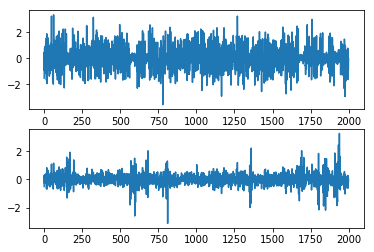

In [6]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(trajectory_generator.traj[:, 0, 0])
ax[1].plot(trajectory_generator.traj[:, 0, 1])

plt.show()

# Estimating the latent state sequnce with the HDPHMM

Now let's use the HDPHMM to estimate the latent state sequence and the AR parameters of the test data. We will first initialize the InfiniteHMM class using the trajectory_generator object. Then we will run the algorithm for a set number of iterations. 

Remember, we aren't providing the algorithm with anything other than the raw trajectory data.

In [289]:
niter = 200  # number of iterations to cycle through
ihmm = hdphmm.InfiniteHMM(trajectory_generator, max_states=5)
ihmm.inference(niter)

  0%|          | 1/200 [00:00<00:30,  6.59it/s]

Fitting 1 2 dimensional trajectories assuming an autoregressive order of 1
[[283   0   2   1   0]
 [  0   0   0   0   0]
 [  1   0 138   0   1]
 [  1   0   2  10   0]
 [  0   0   0   1   6]
 [  1   0   0   0   0]]


  2%|▏         | 3/200 [00:00<00:26,  7.32it/s]

[[276   0   2   0   0]
 [  0   0   0   0   0]
 [  1   0 128   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[271   0   1   0   0]
 [  0   0   0   0   0]
 [  1   0 116   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


  2%|▎         | 5/200 [00:00<00:25,  7.64it/s]

[[229   0   2   0   0]
 [  0   0   0   0   0]
 [  2   0 108   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[249   0   1   1   0]
 [  0   0   0   0   0]
 [  1   0 109   0   0]
 [  1   0   0   1   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


  4%|▎         | 7/200 [00:00<00:24,  7.79it/s]

[[231   0   3   0   0]
 [  0   0   0   0   0]
 [  1   0 114   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[253   0   1   0   0]
 [  0   0   0   0   0]
 [  1   0 105   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


  4%|▍         | 9/200 [00:01<00:24,  7.94it/s]

[[242   0   1   0   0]
 [  0   0   0   0   0]
 [  1   0  96   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[211   0   1   0   0]
 [  0   0   0   0   0]
 [  2   0 109   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


  6%|▌         | 11/200 [00:01<00:23,  8.08it/s]

[[224   0   2   0   0]
 [  0   0   0   0   0]
 [  3   0 117   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[183   0   3   0   0]
 [  0   0   0   0   0]
 [  2   0  90   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


  6%|▋         | 13/200 [00:01<00:23,  8.11it/s]

[[186   0   3   0   0]
 [  0   0   0   0   0]
 [  1   0 104   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[198   0   1   0   0]
 [  0   0   0   0   0]
 [  5   0 116   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


  8%|▊         | 15/200 [00:01<00:22,  8.12it/s]

[[203   0   1   0   0]
 [  0   0   0   0   0]
 [  5   0  89   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[189   0   2   0   0]
 [  0   0   0   0   0]
 [  2   0  96   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


  8%|▊         | 17/200 [00:02<00:22,  8.11it/s]

[[197   0   1   0   0]
 [  0   0   0   0   0]
 [  6   0  90   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[166   0   2   0   0]
 [  0   0   0   0   0]
 [  4   0  83   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


 10%|▉         | 19/200 [00:02<00:22,  8.03it/s]

[[164   0   2   0   0]
 [  0   0   0   0   0]
 [  6   0  80   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[203   0   2   1   0]
 [  0   0   0   0   0]
 [  3   0  85   0   0]
 [  1   0   0  62   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


 10%|█         | 21/200 [00:02<00:22,  7.79it/s]

[[210   0   4   1   0]
 [  0   0   0   0   0]
 [  3   0 104   2   0]
 [  4   0   0 149   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[152   0   4   1   0]
 [  0   0   0   0   0]
 [  3   0  98   1   0]
 [  3   0   2 176   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


 12%|█▏        | 23/200 [00:02<00:22,  7.71it/s]

[[163   0   1   4   0]
 [  0   0   0   0   0]
 [  3   0 105   2   0]
 [  3   0   1 170   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[181   0   1   2   0]
 [  0   0   0   0   0]
 [  2   0 100   2   0]
 [  1   0   1 196   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


 12%|█▎        | 25/200 [00:03<00:22,  7.65it/s]

[[179   0   1   1   0]
 [  0   0   0   0   0]
 [  2   0  92   3   0]
 [  2   0   1 180   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[170   0   1   3   0]
 [  0   0   0   0   0]
 [  2   0 114   3   0]
 [  3   0   1 161   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


 14%|█▎        | 27/200 [00:03<00:22,  7.63it/s]

[[182   0   2   2   0]
 [  0   0   0   0   0]
 [  3   0  89   3   0]
 [  3   0   1 194   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[161   0   2   2   0]
 [  0   0   0   0   0]
 [  3   0 107   2   0]
 [  3   0   2 175   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


 14%|█▍        | 29/200 [00:03<00:22,  7.75it/s]

[[166   0   2   1   0]
 [  0   0   0   0   0]
 [  2   0  98   2   0]
 [  4   0   1 169   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]
[[148   0   1   2   0]
 [  0   0   0   0   0]
 [  2   0 105   5   0]
 [  1   0   1 157   0]
 [  0   0   0   0   0]
 [  1   0   0   0   0]]


KeyboardInterrupt: 

Now it's time to see how the algorithm did.

Found 3 unique states
3 states were used to generate this data

Estimated Transition Matrix:

[[0.9861 0.0062 0.0076]
 [0.0078 0.9844 0.0078]
 [0.0227 0.0168 0.9605]]
Correctly identified 95.4 % of states


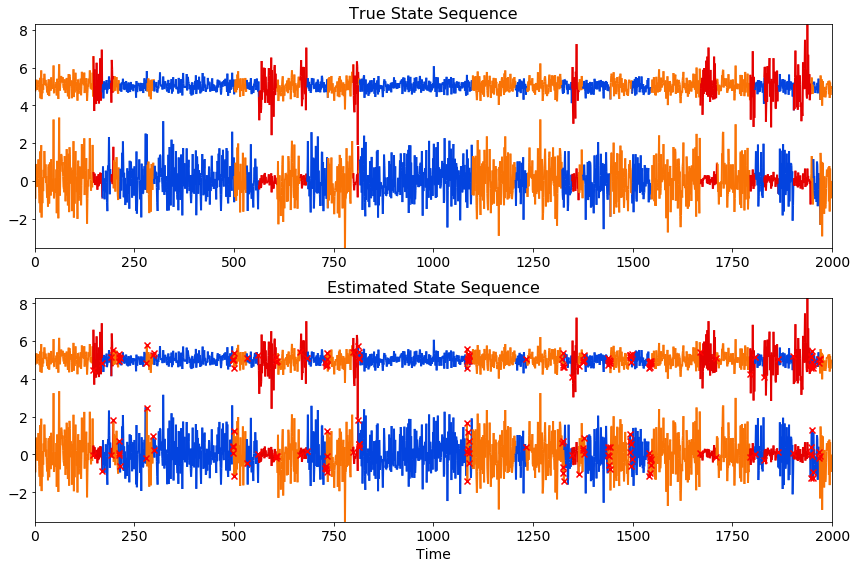

In [257]:
ihmm.summarize_results(traj_no=0)

Not bad! If you are generating trajectories using the same parameters as me, you should be getting about 96 % of the latent states correct. If you're not getting good results try calling the inference method again, perhaps with more iterations.